<b>
<div style="text-align: center;">
    <span style="font-size: 200%;">時間的差分学習 (Temporal Difference Learning)</span>
</div>
</b>

<br>

<b>
<div style="text-align: right;">
    <span style="font-size: 150%;">
        2020/1/28
    </span><br>
    <span style="font-size: 150%;">
        Masaya Mori
    </span>
</div>
</b>

## 目的

<span style="font-size: 120%;"> 時間的差分学習(TD学習)を用いて，Grid Worldの状態価値を導出する．</span> \

## 問題設定

<img src="ProblemSetting.jpg" width="400">

## Pythonによる実装

In [3]:
import numpy as np
import matplotlib.pyplot as plt



class Agent():

    ## クラス変数定義
    # アクションと移動を対応させる辞書 
    GAMMA = 0.9
    ACTIONS = ['right', 'up', 'left', 'down']
    act_dict = {'right':np.array([0,1]), 'up':np.array([-1,0]),\
                'left':np.array([0,-1]), 'down':np.array([1,0])}
    num_action = len(ACTIONS) # 4
    
    
    # 上下左右全て等確率でランダムに移動する
    pi_dict1 = {'right':0.25, 'up':0.25,'left':0.25, 'down':0.25} 
    
    def __init__(self, array_or_list):
        # 入力はリストでもnp.arrayでも良い
        if type(array_or_list) == list:
            array = np.array(array_or_list)
        else:
            array = array_or_list
        assert (array[0] >=0 and array[0] < 5 and \
                array[1] >=0 and array[1] <5)
        self.pos = array
    
    # 現在位置を返す
    def get_pos(self):
        return self.pos
    
    # 現在位置をセットする
    def set_pos(self, array_or_list):
        if type(array_or_list) == list:
            array = np.array(array_or_list)
        else:
            array = array_or_list
        assert (array[0] >=0 and array[0] < 5 and \
                array[1] >=0 and array[1] <5)
        self.pos = array
    
    # 現在位置から移動
    def move(self, action):
    
        # 辞書を参照し、action名から移動量move_coordを取得
        move_coord = Agent.act_dict[action] 
    
        # A地点
        if (self.get_pos() == np.array([0,1])).all():
            pos_new = [4,1]
        # B地点
        elif (self.get_pos() == np.array([0,3])).all():
            pos_new = [2,3]
        else:
            pos_new = self.get_pos() + move_coord
        # グリッドの外には出られない
        pos_new[0] = np.clip(pos_new[0], 0, 4)
        pos_new[1] = np.clip(pos_new[1], 0, 4)
        self.set_pos(pos_new)
    
    # 現在位置から移動することによる報酬。この関数では移動自体は行わない
    def reward(self, state, action):
        # A地点
        if (state == np.array([0,1])).all():
            r = 10
            return r
        # B地点
        if (state == np.array([0,3])).all():
            r = 5
            return r
    
        # グリッドの境界にいて時に壁を抜けようとした時には罰則
        if (state[0] == 0 and action == 'up'):
            r = -1
        elif(state[0] == 4 and action == 'down'):
            r = -1
        elif(state[1] == 0 and action == 'left'):
            r = -1
        elif(state[1] == 4 and action == 'right'):
            r = -1
        # それ以外は報酬0
        else:
            r = 0
        return r
    
    def pi(self, state, action):
        # 変数としてstateを持っているが、実際にはstateには依存しない
        return Agent.pi_dict1[action]
    
    
    def V_pi(self, state, n, out, iter_num):
        # state:関数呼び出し時の状態
        # n:再帰関数の呼び出し回数。関数実行時は1を指定
        # out:返り値用の変数。関数実行時は0を指定
    
        if n==iter_num:    # 終端状態
            for i, action in enumerate(self.ACTIONS):
                out += self.pi(state, action) * self.reward(state,action)
            return out
        else:
            for i, action in enumerate(self.ACTIONS):
                out += self.pi(state, action)  * self.reward(self.get_pos(),action) # 報酬
                self.move(action) # 移動してself.get_pos()の値が更新
    
                ## 価値関数を再帰呼び出し
                # state変数には動いた先の位置、つまりself.get_pos()を使用
                out +=  self.pi(self.get_pos(), action) * \
                        self.V_pi(self.get_pos(), n+1, 0,  iter_num) * self.GAMMA
                self.set_pos(state) #  再帰先から戻ったらエージェントを元の地点に初期化
            return out
    
    def Q_pi(self, state, action,  n, out, iter_num):
            #print('\nnow entering Q_pi at n=%d, state=%s, action:%s' %(n, str(state), action))
            # state:関数呼び出し時の状態
            # n:再帰関数の呼び出し回数。関数実行時は1を指定
            # out:返り値用の変数。関数実行時は0を指定
       
            if n==iter_num:    # 終端状態
                out += self.pi(state, action) * self.reward(state,action)
                #print("terminal condition")
                return out
            else:
                out += self.reward(state,action) # 報酬
                self.set_pos(state)
                self.move(action) # 移動してself.get_pos()の値が更新
    
                state_before_recursion = self.get_pos()
    
                ## 価値関数を再帰呼び出し
                for next_action in self.ACTIONS:
                    out +=  self.pi(state_before_recursion, next_action) * \
                            self.Q_pi(state_before_recursion, next_action,  n+1, 0,  iter_num) * self.GAMMA
                    self.set_pos(state) #  再帰先から戻ったらエージェントを元の地点に初期化
                    #print("agent pos set to %s, at n:%d" % (str(state), n))
                return out

# 最適行動に赤色のラベル、他には指定したカラーラベルをつける
def if_true_color_red(val, else_color):
    if val:
        return 'r'
    else:
        return else_color


def Q_value_plot(Q):
    max_bool = Q == np.max(Q, axis=0)
    max_color_k = np.vectorize(if_true_color_red)(max_bool,'k')
    max_color_w = np.vectorize(if_true_color_red)(max_bool,'w')
    q_array_round = np.round(Q, decimals=2)
    # 行動価値関数を表示
    ax = plt.gca()
    plt.xlim(0,5)
    plt.ylim(0,5)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    for i in range(5):
        for j in range(5):
            # rect
            rect = plt.Rectangle(xy =(i,j) , width=1, height=1, fill=False)
            ax.add_patch(rect)
            # diag
            diag = plt.Line2D(xdata=(i,i+1), ydata=(j,j+1),color='k',linewidth=.5)
            ax.add_line(diag)
            diag = plt.Line2D(xdata=(i,i+1), ydata=(j+1,j),color='k',linewidth=.5)
            ax.add_line(diag)
            # 座標のインデックスの調整
            x = -j-1 
            y = i
            # text
            plt.text(i+ 0.65, j+0.45, "%s" % (str(q_array_round[0,x,y])), color=max_color_k[0,x,y])
            plt.text(i+ 0.4, j+0.8, "%s" % (str(q_array_round[1,x,y])), color=max_color_k[1,x,y])
    
            plt.text(i+ 0.025, j+0.45, "%s" % (str(q_array_round[2,x,y])), color=max_color_k[2,x,y])
    
            plt.text(i+ 0.4, j+0.1, "%s" % (str(q_array_round[3,x,y])), color=max_color_k[3,x,y])
    plt.show()


def Q_arrow_plot(Q):
    max_bool = Q == np.max(Q, axis=0)
    max_color_k = np.vectorize(if_true_color_red)(max_bool,'k')
    max_color_w = np.vectorize(if_true_color_red)(max_bool,'w')
    q_array_round = np.round(Q, decimals=2)
    # 最適行動を矢印で表示
    ax = plt.gca()
    plt.xlim(0,5)
    plt.ylim(0,5) 
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    for i in range(5):
        for j in range(5):
            # rect
            rect = plt.Rectangle(xy =(i,j) , width=1, height=1, fill=False)
            ax.add_patch(rect)
            # 座標のインデックスの調整
            x = -j-1 
            y = i
            # arrow
            plt.arrow(i+ 0.5, j+0.5, 0.2, 0, width=0.01,head_width=0.15,\
                head_length=0.2,color=max_color_w[0,x,y])
            plt.arrow(i+ 0.5, j+0.5, 0, 0.2, width=0.01,head_width=0.15,\
                head_length=0.2, color=max_color_w[1,x,y])
            plt.arrow(i+ 0.5, j+0.5, -0.2, 0, width=0.01,head_width=0.15,\
                head_length=0.2, color=max_color_w[2,x,y])
            plt.arrow(i+ 0.5, j+0.5, 0, -0.2, width=0.01,head_width=0.15,\
                head_length=0.2, color=max_color_w[3,x,y])
    plt.show()

def V_value_plot(V):
    # 状態価値関数を表示
    ax = plt.gca()
    plt.xlim(0,5)
    plt.ylim(0,5)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    v_array_round = np.round(V, decimals=2)
    for i in range(5):
        for j in range(5):
            # rect
            rect = plt.Rectangle(xy =(i,j) , width=1, height=1, fill=False)
            ax.add_patch(rect)
            # 座標のインデックスの調整
            x = -j-1 
            y = i
            # text
            plt.text(i+ 0.4, j+0.5, "%s" % (str(v_array_round[x,y])))
    plt.show()

def pi_arrow_plot(pi):
    # 最適行動を矢印で表示
    ax = plt.gca()
    plt.xlim(0,5)
    plt.ylim(0,5) 
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    
    for i in range(5):
        for j in range(5):
            # rect
            rect = plt.Rectangle(xy =(i,j) , width=1, height=1, fill=False)
            ax.add_patch(rect)
            # 座標のインデックスの調整
            x = -j-1 
            y = i
            # arrow
            if pi[x,y] ==0:
                plt.arrow(i+ 0.5, j+0.5, 0.2, 0, width=0.01,head_width=0.15,\
                    head_length=0.2,color='r')
            elif pi[x,y] ==1:
                plt.arrow(i+ 0.5, j+0.5, 0, 0.2, width=0.01,head_width=0.15,\
                    head_length=0.2, color='r')
            elif pi[x,y] ==2:
                plt.arrow(i+ 0.5, j+0.5, -0.2, 0, width=0.01,head_width=0.15,\
                    head_length=0.2, color='r')
            elif pi[x,y] ==3:
                plt.arrow(i+ 0.5, j+0.5, 0, -0.2, width=0.01,head_width=0.15,\
                    head_length=0.2, color='r')
    plt.show()
    plt.close()

start iteration


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:49<00:00, 59.12it/s]


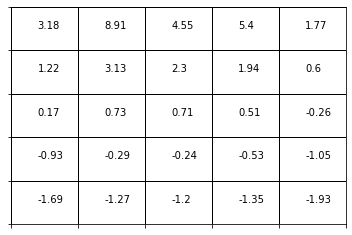

In [7]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

   
# agentの生成
agent = Agent([0,0])

ALPHA = 0.01
GAMMA = 0.9
ACTIONS = ['right', 'up', 'left', 'down']
num_row = 5 
num_col = 5
num_iteration = 100 # エピソード終了までの反復回数
num_episode = 10000 # サンプリング数
# piの設定
def pi(): # 状態sによらない方策
    return np.random.randint(0,4) # 上下左右がランダム


# Vの初期化
V = np.zeros((5,5))


print("start iteration")

count = 0

V_trend = np.zeros((num_episode, num_row, num_col))

for epi in tqdm(range(num_episode)):
    delta = 0
    i,j = np.random.randint(5, size=2)
    agent.set_pos([i,j]) # 移動前の状態に初期化
    s = agent.get_pos()
    for k in range(num_iteration):
        action = ACTIONS[np.random.randint(0,4)] 
        agent.move(action) # 移動
        s_dash = agent.get_pos() # 移動後の状態
        reward = agent.reward(s, action)
        V[s[0],s[1]] = V[s[0],s[1]] + ALPHA*(reward + GAMMA*V[s_dash[0], s_dash[1]]  - V[s[0],s[1]])
        s = agent.get_pos()


# 状態価値関数の表示
V_value_plot(V) 

## 結果

<img src="fixed_outcome.jpg" width="400">

<center>
<span style="font-size: 120%;"> This is the state value when using recursion.</span>

<img src="ProblemSetting.jpg" width="400">